In [1]:
%matplotlib inline  
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime
import plotly

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from math import sqrt

In [2]:
# Set up functions
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# measure_rmse([1,2],[1,3])

In [3]:
#train_test_split([1,2,3,4,5],2)
def train_test_split(data, n_train):
    train = data.iloc[:n_train]
    test = data.iloc[n_train:]
    return train,test

In [4]:
# Complete code example found online - ended up modifiying the code so I could more easily use it with various segments of the incidents data
def evaluate_forecast(series,freq="M"):
    data = series
    n_training = int(len(data)*0.8) # percentage used for test
    max_length = len(data) - n_training
    print("Training size %s " % n_training)
    print("Test size %s " % max_length)
    cfg_list = [1]
    train, test = train_test_split(data, n_training)
    m = Prophet(mcmc_samples=500,seasonality_mode='multiplicative').fit(series);
    future = m.make_future_dataframe(periods=len(test),freq=freq)
    forecast = m.predict(future)
    m.plot(forecast)
    print("RMSE: %s" % measure_rmse(forecast.iloc[len(train):len(series)]["yhat"],test["y"]))

## Read in incident data and prep for prophet run

In [5]:
# Read in the CSV
incidents = pd.read_csv("../incident_data/yearly_incident_data/all_incidents.csv", low_memory=False)
incidents = incidents.dropna()
incidents.head()

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime
0,0056Xx Lyndale Av S,MP2010000051,5,CSCR,Crim Sex Cond-Rape,3.0,44.900291,-93.288239,Windom,2010/01/01,00:30
1,0001Xx 62 St W,MP2010000099,5,ROBPAG,Robbery Per Agg,4.0,44.890636,-93.280041,Windom,2010/01/01,01:05
2,0039Xx 5 Av S,MP2010000373,3,BURGD,Burglary Of Dwelling,6.0,44.931448,-93.268841,Bryant,2010/01/01,04:18
3,0013Xx Nicollet Av S,MP2010000305,1,ASLT2,Asslt W/Dngrs Weapon,5.0,44.970506,-93.277714,Loring Park,2010/01/01,03:00
4,0034Xx Oliver Av N,MP2010000229,4,BURGD,Burglary Of Dwelling,6.0,45.017746,-93.306988,Folwell,2010/01/01,02:23


In [6]:
# Create a new DF that counts number of entries by date
counts = incidents.groupby(['incidentDate']).count()
counts

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentTime
incidentDate,,,,,,,,,,
2010/01/01,62,62,62,62,62,62,62,62,62,62
2010/01/02,38,38,38,38,38,38,38,38,38,38
2010/01/03,37,37,37,37,37,37,37,37,37,37
2010/01/04,62,62,62,62,62,62,62,62,62,62
2010/01/05,44,44,44,44,44,44,44,44,44,44
...,...,...,...,...,...,...,...,...,...,...
2020/12/26,32,32,32,32,32,32,32,32,32,32
2020/12/27,31,31,31,31,31,31,31,31,31,31
2020/12/28,46,46,46,46,46,46,46,46,46,46


In [7]:
# Set up a full series with all days for evaluation
series = counts.filter(['caseNumber'], axis=1)
series = series.reset_index()
series.rename(columns={'incidentDate':'ds', 'caseNumber':'y'}, inplace=True)
series.head()

,ds,y
0,2010/01/01,62
1,2010/01/02,38
2,2010/01/03,37
3,2010/01/04,62
4,2010/01/05,44


In [8]:
# Set up the series DF to feed into prophet
series['ds'] = pd.to_datetime(series['ds'])
series[['y']] = series[['y']].astype(float)
series = series[['ds','y']]
series.head()

,ds,y
0,2010-01-01,62.0
1,2010-01-02,38.0
2,2010-01-03,37.0
3,2010-01-04,62.0
4,2010-01-05,44.0


In [ ]:
# This takes about 40 minutes to run
evaluate_forecast(series, freq='W')

## Starting a prophet run from scratch - used while learning/testing the prophet framework

In [18]:
# Grab a smaller set of daily data to do some testing
series_slim = series[series['ds']>='2015-01-01']
series_slim

,ds,y
1826,2015-01-01,61.0
1827,2015-01-02,51.0
1828,2015-01-03,48.0
1829,2015-01-04,36.0
1830,2015-01-05,36.0
...,...,...
4012,2020-12-26,32.0
4013,2020-12-27,31.0
4014,2020-12-28,46.0
4015,2020-12-29,22.0


In [19]:
# Set up the model as a Prophet instance and fit the dataframe
model = Prophet()
model.fit(series_slim)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
# Set up the future dates for predictions
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
2551,2021-12-26
2552,2021-12-27
2553,2021-12-28
2554,2021-12-29
2555,2021-12-30


In [21]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2551,2021-12-26,45.281912,30.845478,59.220274
2552,2021-12-27,45.504004,30.668647,60.785198
2553,2021-12-28,43.604873,29.539186,58.767910
2554,2021-12-29,43.899519,30.326527,59.064474
2555,2021-12-30,43.983928,29.989063,59.296359


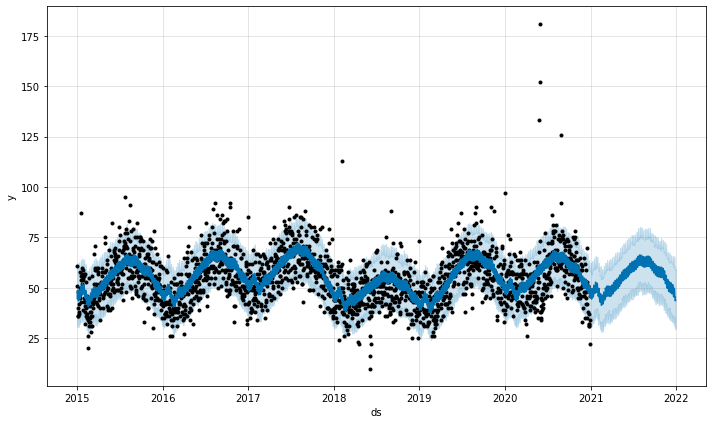

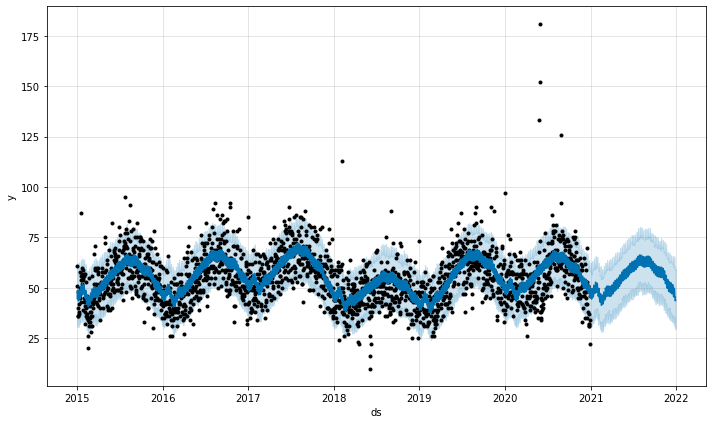

In [22]:
model.plot(forecast)

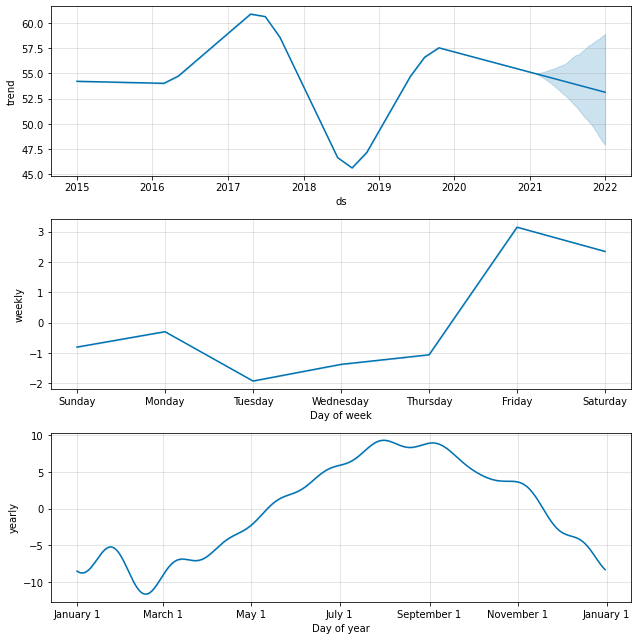

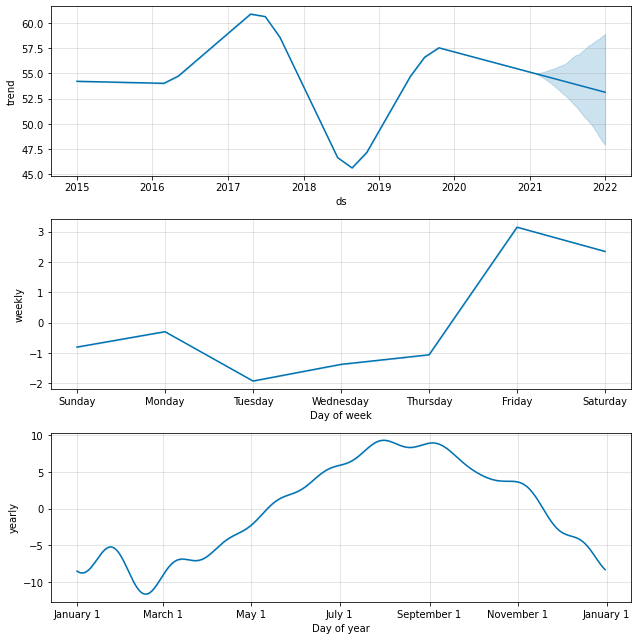

In [23]:
## Break out the seasonal components
model.plot_components(forecast)

In [24]:
plot_plotly(model, forecast)

In [25]:
plot_components_plotly(model, forecast)

## Run the model on a weekly basis

In [26]:
# Get the daily casecounts
counts_reduced = counts[['caseNumber']]
counts_reduced

,caseNumber
incidentDate,
2010/01/01,62
2010/01/02,38
2010/01/03,37
2010/01/04,62
2010/01/05,44
...,...
2020/12/26,32
2020/12/27,31
2020/12/28,46


In [27]:
# Transpose the DF for grouping
counts_transposed = counts_reduced.T
counts_transposed

incidentDate,2010/01/01,2010/01/02,2010/01/03,2010/01/04,2010/01/05,2010/01/06,2010/01/07,2010/01/08,2010/01/09,2010/01/10,...,2020/12/21,2020/12/22,2020/12/23,2020/12/24,2020/12/25,2020/12/26,2020/12/27,2020/12/28,2020/12/29,2020/12/30
caseNumber,62,38,37,62,44,37,48,54,31,33,...,38,51,37,32,31,32,31,46,22,34


In [28]:
# Group into weeks, then transpose again
counts_grouped = counts_transposed.groupby([[i//7 for i in range(0,4017)]], axis=1).sum().T

# Get the 'week of' dates
date_range = pd.period_range(start='2010-01-01', end='2020-12-31', freq='W-SUN')
date_range = date_range.map(str)
date_range = date_range.str.split('/').str[0]
date_range = pd.Series(date_range)

counts_grouped = counts_grouped.assign(Weeks=date_range)
# counts_grouped.tail()

counts_grouped.set_index(['Weeks']).head()

,caseNumber
Weeks,
2009-12-28,328
2010-01-04,274
2010-01-11,329
2010-01-18,280
2010-01-25,263


In [29]:
counts_grouped = counts_grouped.reset_index()
counts_grouped.rename(columns={'Weeks':'ds', 'caseNumber':'y'}, inplace=True)

,index,y,ds
0,0,328,2009-12-28
1,1,274,2010-01-04
2,2,329,2010-01-11
3,3,280,2010-01-18
4,4,263,2010-01-25


In [30]:
# Set up the series DF to feed into prophet
counts_grouped['ds'] = pd.to_datetime(counts_grouped['ds'])
counts_grouped[['y']] = counts_grouped[['y']].astype(float)
counts_grouped = counts_grouped[['ds','y']]
counts_grouped

,ds,y
0,2009-12-28,328.0
1,2010-01-04,274.0
2,2010-01-11,329.0
3,2010-01-18,280.0
4,2010-01-25,263.0
...,...,...
569,2020-11-23,343.0
570,2020-11-30,366.0
571,2020-12-07,318.0
572,2020-12-14,329.0


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Training size 459 
Test size 115 
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
RMSE: 43.316155566530576


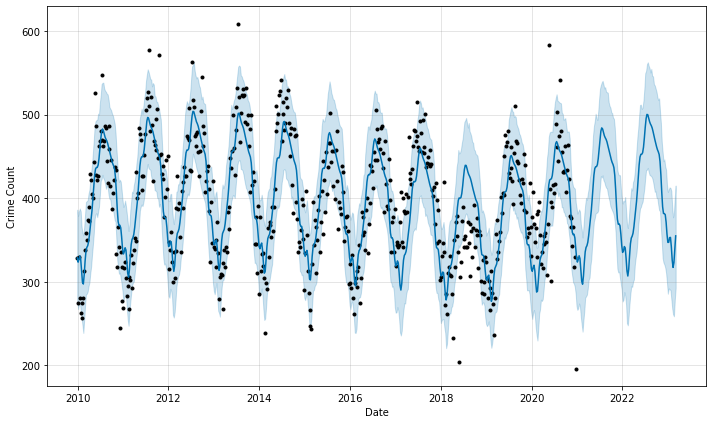

In [31]:
# Split and fit the model with the weekly data and then plot
data = counts_grouped
n_training = int(len(data)*0.8) # percentage used for test
max_length = len(data) - n_training
print("Training size %s " % n_training)
print("Test size %s " % max_length)
cfg_list = [1]
train, test = train_test_split(data, n_training)
m = Prophet(mcmc_samples=500,seasonality_mode='multiplicative').fit(counts_grouped);
future = m.make_future_dataframe(periods=len(test),freq='W')
forecast = m.predict(future)
m.plot(forecast, xlabel='Date', ylabel='Crime Count')
plt.savefig('images/prophet_weekly_forecast.png')

print("RMSE: %s" % measure_rmse(forecast.iloc[len(train):len(counts_grouped)]["yhat"],test["y"]))

C:\Users\hasse\anaconda3\envs\PythonAdv\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



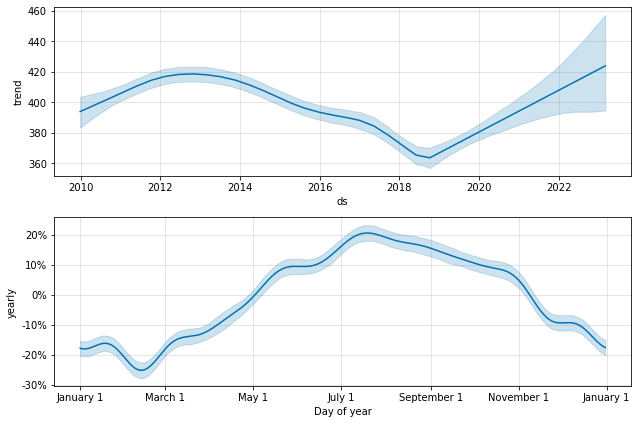

In [32]:
m.plot_components(forecast)
plt.savefig('images/prophet_weekly_trends.png')

In [33]:
plot_plotly(m, forecast, xlabel='Date', ylabel='Crime Count')

In [34]:
plot_components_plotly(m, forecast)

In [35]:
plotly.offline.plot(plot_plotly(m, forecast, xlabel='Date', ylabel='Crime Count'))

'temp-plot.html'

In [36]:
plotly.offline.plot(plot_components_plotly(m, forecast))

'temp-plot.html'